In [76]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

data = pd.read_csv('train_data.csv')

# sequence 길이 (frame 개수)
sequence_length = 5

# 라벨 인코딩
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

def split_sequences(data, sequence_length): # 5개 프레임으로 쪼개는 함수
    X, y = [], []
    scaler = StandardScaler()
    imputer = SimpleImputer(strategy='mean')
    data_values = data.iloc[:, 2:-1].values  
    data_values = imputer.fit_transform(data_values)  # nan값 처리
    data_values = scaler.fit_transform(data_values)  # 정규화
    for i in range(len(data) - sequence_length):
        sequence = data_values[i:i+sequence_length]
        label = data.iloc[i+sequence_length, -1]
        X.append(sequence)
        y.append(label)
    return np.array(X), np.array(y)

# 데이터와 라벨 분할
X, y = split_sequences(filled_data, sequence_length)


In [79]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Numpy를 Tensor로 변환
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

# 학습에 사용할 데이터 로더
class Sequence_Dataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

train_dataset = Sequence_Dataset(X_train, y_train)
test_dataset = Sequence_Dataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# LSTM 모델
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        h_n = h_n.squeeze(0)
        output = self.fc(h_n)
        return output

input_size = X.shape[2]
hidden_size = 64
num_classes = len(label_encoder.classes_)

model = LSTMModel(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_loss_log = []
valid_accuracy_log = []

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    epoch_loss = running_loss / len(train_dataloader)
    train_loss_log.append(epoch_loss)
    print(f'epoch [{epoch+1}/{num_epochs}], train Loss: {running_loss:.4f}')
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = correct / total
    valid_accuracy_log.append(accuracy)
    print(f'epoch [{epoch+1}/{num_epochs}], Valid Accuracy: {accuracy:.4f}')


epoch [1/20], train Loss: 12.4285
epoch [1/20], Valid Accuracy: 0.6667
epoch [2/20], train Loss: 11.0094
epoch [2/20], Valid Accuracy: 0.6771
epoch [3/20], train Loss: 9.2677
epoch [3/20], Valid Accuracy: 0.6875
epoch [4/20], train Loss: 7.1619
epoch [4/20], Valid Accuracy: 0.7604
epoch [5/20], train Loss: 5.3463
epoch [5/20], Valid Accuracy: 0.8646
epoch [6/20], train Loss: 3.9190
epoch [6/20], Valid Accuracy: 0.9062
epoch [7/20], train Loss: 2.6956
epoch [7/20], Valid Accuracy: 0.9167
epoch [8/20], train Loss: 1.9819
epoch [8/20], Valid Accuracy: 0.9271
epoch [9/20], train Loss: 1.4405
epoch [9/20], Valid Accuracy: 0.9375
epoch [10/20], train Loss: 1.0730
epoch [10/20], Valid Accuracy: 0.9583
epoch [11/20], train Loss: 0.7477
epoch [11/20], Valid Accuracy: 0.9688
epoch [12/20], train Loss: 0.5200
epoch [12/20], Valid Accuracy: 0.9896
epoch [13/20], train Loss: 0.3709
epoch [13/20], Valid Accuracy: 0.9896
epoch [14/20], train Loss: 0.2690
epoch [14/20], Valid Accuracy: 0.9896
epoch [1

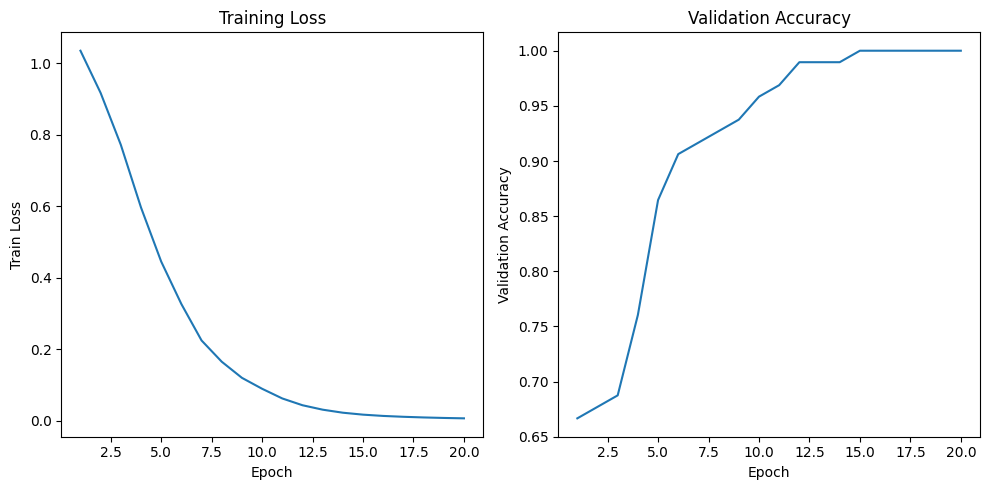

In [80]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_loss_log)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), valid_accuracy_log)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()